In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Reshape
from sklearn.utils import resample
import matplotlib.pyplot as plt


In [84]:
# Carregando o dataset
data = pd.read_csv('C:/Users/mrsilva/Pessoal/Senac/creditcard_2023.csv')

# Contando a quantidade de transações fraudulentas
num_frauds = data['Class'].sum()
print(f"Número de transações fraudulentas: {num_frauds}")

Número de transações fraudulentas: 284315


In [85]:
# Separando features e target
X = data.drop(['Class', 'id'], axis=1)
y = data['Class']


In [86]:
# Dividindo o conjunto de dados em treino, validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [87]:
# Separar as classes majoritária e minoritária
major_class = data[data['Class'] == 0]
minor_class = data[data['Class'] == 1]

# Fazer oversampling da classe minoritária para igualar à classe majoritária
minor_oversampled = resample(minor_class, replace=True, n_samples=len(major_class), random_state=42)

# Combinar as classes reamostradas com a classe majoritária
balanced_data = pd.concat([major_class, minor_oversampled])


In [88]:
# Separando novamente os dados balanceados em features e target
X_balanced = balanced_data.drop(['Class', 'id'], axis=1)
y_balanced = balanced_data['Class']

In [89]:
# Dividindo os dados balanceados em treino e teste
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Dividindo o conjunto de treinamento balanceado em treinamento final e validação
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


In [90]:
# Modelo Convolutional Neural Network (CNN)
from tensorflow.keras.layers import Dropout

def build_cnn_model_with_dropout():
    input_layer = Input(shape=(X_train_final.shape[1],))  
    x = Reshape((X_train_final.shape[1], 1))(input_layer) 
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)  # Exemplo de adição de Dropout após a camada de pooling
    x = Flatten()(x)
    x = Dropout(0.5)(x)  # Adicionando Dropout antes da camada densa
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [91]:
# Preparando dados balanceados para a CNN com novo input_shape
X_train_final_cnn = X_train_final.values.reshape((X_train_final.shape[0], X_train_final.shape[1], 1))
X_val_cnn = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_balanced_cnn = X_test_balanced.values.reshape((X_test_balanced.shape[0], X_test_balanced.shape[1], 1))


In [92]:
# Treinando o modelo com o conjunto final de treinamento e validação
cnn_model = build_cnn_model_with_dropout()
history = cnn_model.fit(X_train_final_cnn, y_train_final, epochs=10, batch_size=64, validation_data=(X_val_cnn, y_val))


Epoch 1/10
5687/5687 [==============================] - 44s 8ms/step - loss: 0.1208 - accuracy: 0.9560 - val_loss: 0.0827 - val_accuracy: 0.9682
Epoch 2/10
5687/5687 [==============================] - 43s 7ms/step - loss: 0.0983 - accuracy: 0.9645 - val_loss: 0.0784 - val_accuracy: 0.9696
Epoch 3/10
5687/5687 [==============================] - 30s 5ms/step - loss: 0.0964 - accuracy: 0.9652 - val_loss: 0.0765 - val_accuracy: 0.9726
Epoch 4/10
5687/5687 [==============================] - 26s 5ms/step - loss: 0.0957 - accuracy: 0.9658 - val_loss: 0.0743 - val_accuracy: 0.9723
Epoch 5/10
5687/5687 [==============================] - 40s 7ms/step - loss: 0.0938 - accuracy: 0.9666 - val_loss: 0.0737 - val_accuracy: 0.9717
Epoch 6/10
5687/5687 [==============================] - 40s 7ms/step - loss: 0.0933 - accuracy: 0.9664 - val_loss: 0.0728 - val_accuracy: 0.9728
Epoch 7/10
5687/5687 [==============================] - 33s 6ms/step - loss: 0.0920 - accuracy: 0.9671 - val_loss: 0.0745 - val_ac

In [93]:
cnn_model.save('CNN_fraude_cartao.h5')

c:\Users\mrsilva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [94]:
# Realizando previsões com a CNN nos dados de validação
cnn_predictions_val = cnn_model.predict(X_val_cnn)
cnn_predictions_val = np.round(cnn_predictions_val)

2844/2844 [==============================] - 5s 2ms/step


In [95]:
# Avaliar o desempenho da CNN nos dados de validação
cnn_accuracy_val = accuracy_score(y_val, cnn_predictions_val)
cnn_precision_val = precision_score(y_val, cnn_predictions_val)
cnn_recall_val = recall_score(y_val, cnn_predictions_val)
cnn_f1_val = f1_score(y_val, cnn_predictions_val)

In [96]:
print("\n------CNN Metrics on Validation Data:---------\n")
print(f"Accuracy: {cnn_accuracy_val}\n")
print(f"Confusion Matrix:\n{cnn_confusion_val}")
print(f"Precision: {cnn_precision_val}\n")
print(f"Recall: {cnn_recall_val}\n")
print(f"F1 Score: {cnn_f1_val}")


------CNN Metrics on Validation Data:---------

Accuracy: 0.9730822919071015

Confusion Matrix:
[[45080   587]
 [ 2014 43300]]
Precision: 0.9866046089226927

Recall: 0.9589751511674096

F1 Score: 0.972593695095066


# Analise de resultados

## Matriz de Confusão:
Um gráfico que compara as previsões da rede neural com os resultados reais, mostrando os verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. Isso ajuda a avaliar o desempenho do modelo.


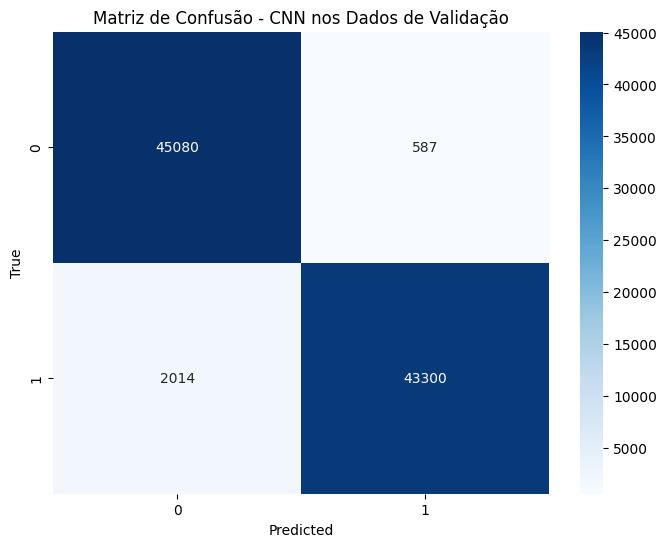

In [97]:
import seaborn as sns

# Matriz de Confusão para a CNN nos dados de validação
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_confusion_val, annot=True, cmap='Blues', fmt='g')

plt.title('Matriz de Confusão - CNN nos Dados de Validação')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()


## Curva ROC (Receiver Operating Characteristic):
Essa curva mostra a taxa de verdadeiros positivos em comparação com a taxa de falsos positivos para diferentes limiares de decisão do modelo. Uma área sob a curva (AUC) próxima de 1 indica um bom desempenho na detecção de fraudes.

2844/2844 [==============================] - 3s 1ms/step


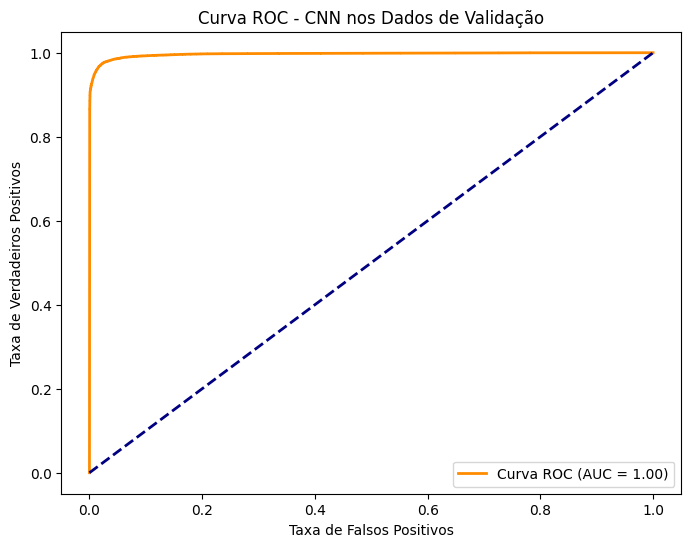

In [98]:
from sklearn.metrics import roc_curve, auc

# Calculando as probabilidades previstas para a classe positiva (fraude) da CNN
cnn_probabilities_val = cnn_model.predict(X_val_cnn)
fpr, tpr, thresholds = roc_curve(y_val, cnn_probabilities_val)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - CNN nos Dados de Validação')
plt.legend(loc='lower right')

plt.show()
